# TimeGAN Sythetic Data Backtesting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.saving import load_model

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

2024-04-24 18:08:48.301312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 18:08:48.301367: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 18:08:48.301375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 18:08:48.307860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
experiment = 0

In [5]:
path = Path('time_gan_research_control')
hdf_store = path / 'TimeSeriesGAN.h5'
results_path = Path('time_gan_research_control')
log_dir = results_path / f'experiment_{experiment:02}'

# Parameters

In [6]:
seq_len = 24 #window of time (days) that model uses to predict last (24th) day
n_seq = 6 #ticker count
batch_size = 128

start_date, end_date = '2000-01-01', '2022-12-01' #ticker price data yyyy-mm-dd
train_test_split = 0.8

In [7]:
scaler = MinMaxScaler()

In [8]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

# Real Data Prep

In [9]:
def get_real_data():
    df = yf.download(tickers, start_date, end_date)['Adj Close']
    # Preprocess the dataset:
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data, df, df.index


real_data, yf_df, yf_index = get_real_data()


[*********************100%%**********************]  6 of 6 completed


In [10]:
n_windows = len(real_data)

# Sythetic Data Prep

In [11]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [12]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

2024-04-24 18:08:53.029862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38386 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [13]:
synthetic_data_keras = load_model(log_dir / "synthetic_data.keras")

In [14]:
print(synthetic_data_keras.summary())

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 28854 (112.71 KB)
Trainable params: 28854 (112.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
#every time this is called, a new sythetic series is generated
def generate_data():
    generated_data = []
    for i in range(int(n_windows / batch_size)):
        Z_ = next(random_series)
        d = synthetic_data_keras(Z_)
        generated_data.append(d)
    generated_data = np.array(np.vstack(generated_data))
    #generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
    return generated_data

# Models

In [16]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)),
                        Dense(6)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [17]:
#synthetic_data = generate_data()
#len(synthetic_data)

In [18]:
#Set indecies for train/test splits
real_data = np.array(real_data)[:5632] #Length of sythetic data

n_series = real_data.shape[0]

idx = np.arange(n_series)

n_train = int(train_test_split*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [19]:
real_test_data = real_data[test_idx, :seq_len-1, :]
real_test_label = real_data[test_idx, -1, :]

In [20]:
def model_predictions(data, train_idx):
    data_train = data[train_idx, :seq_len-1, :]
    data_label = data[train_idx, -1, :]

    ts_regression = get_model()
    synthetic_result = ts_regression.fit(x=data_train,
                                        y=data_label,
                                        validation_data=(
                                            real_test_data, 
                                            real_test_label),
                                        epochs=100,
                                        batch_size=batch_size,
                                        verbose=0)
    test_predict_scaled = ts_regression.predict(real_test_data, verbose=0)
    test_predict = pd.DataFrame(scaler.inverse_transform(test_predict_scaled).squeeze())
    return test_predict

In [21]:
#test_predict = model_predictions(real_data, train_idx)

In [22]:
#Reverse real data back from scaler
real_unscaled = pd.DataFrame(scaler.inverse_transform(real_test_label).squeeze())

In [23]:
#Set index to dates
real_unscaled = real_unscaled.set_index(yf_index[test_idx])
#test_predict = test_predict.set_index(yf_index[test_idx])

In [24]:
def plot_preformance(real, predict, filename):
    ticker_count = len(tickers)
    fig, axes = plt.subplots(nrows=ticker_count//2, ncols=2, 
                             figsize=(int(ticker_count*14/6), int(ticker_count*7/6)))
    axes = axes.flatten()

    for j, ticker in enumerate(tickers):
        (pd.DataFrame({'Real': real.iloc[:, j],
                    'Synthetic Trained': predict.iloc[:, j]})
        .plot(ax=axes[j],
            title=ticker,
            secondary_y='Synthetic', style=['-', '--'],
            lw=1))
    sns.despine()
    fig.tight_layout()
    fig.savefig(filename)

#plot_preformance(real_unscaled, test_predict)

# Backtesting

In [25]:
#To Get our Backtestingpy strategy to work nice with different tickers
#We have to create a new class for each ticker
def ModelStrategy(ticker_series):
    class ModelStrategy_Inst(Strategy):
        percent_to_beat = 0.05

        def init(self):
            self.predict_iter = iter(ticker_series.to_numpy())
            self.price_today = next(self.predict_iter)

        def next(self):
            price_tomorrow = next(self.predict_iter)
            if price_tomorrow > self.price_today+self.price_today*self.percent_to_beat:
                self.buy()
            elif price_tomorrow < self.price_today-self.price_today*self.percent_to_beat:
                self.sell()
            self.price_today = price_tomorrow
    return ModelStrategy_Inst

In [26]:
#Backtesting On Each Stock 
def backtest(prediction):
    return_percents = [0]*len(tickers)
    stats_dict = {}
    bt_dict = {}
    for idx in range(len(tickers)):
        #YF redownload all values as needed by backtesting
        price_df = yf.download(tickers[idx], prediction.index[0], prediction.index[-1])
        #Initiate and optimize backtest based on best percent_to_beat value
        bt = Backtest(price_df, ModelStrategy(prediction[idx]), commission=0.002, exclusive_orders=True)
        stats_opt = bt.run()
        return_percents[idx] = stats_opt["Return [%]"]
        stats_dict.update({tickers[idx]: stats_opt})
        bt_dict.update({tickers[idx]: bt})
    return return_percents, stats_dict, bt_dict

#return_percents, stats_dict, bt_dict = backtest(test_predict)


# Real Looping

In [27]:
iterations = 15

In [28]:
best_real_model = None
best_real_return_avg = 0
best_real_test_predict = None
for k in range(iterations):
    print("Iteration: "+str(k))

    test_predict = model_predictions(real_data, train_idx)
    test_predict = test_predict.set_index(yf_index[test_idx])

    return_percents, stats_dict, bt_dict = backtest(test_predict)
    return_avg = np.average(return_percents)

    if best_real_model==None or best_real_return_avg<return_avg:
        best_real_model = return_percents, stats_dict, bt_dict
        best_real_return_avg = return_avg
        best_real_test_predict = test_predict
        print("New Best With Returns: "+str(best_real_model[0]))

Iteration: 0


2024-04-24 18:08:57.858558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-04-24 18:08:58.085468: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x155318002f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 18:08:58.085512: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-04-24 18:08:58.090822: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 18:08:58.167485: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%************

New Best With Returns: [-77.99922792129516, -49.8453447317505, 181.25166139007567, 174.15466085475924, 23.837956463165284, -16.556576628952044]
Iteration: 1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


New Best With Returns: [-22.066603579559278, -89.09949192382813, 158.7687573927307, 373.4645799435424, -23.827069329071065, -18.54208638153077]
Iteration: 2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


New Best With Returns: [16.931838530883812, -71.49067408691407, -4.027897493133569, 428.28933771656017, 45.62826262802117, -15.965762947692856]
Iteration: 7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


New Best With Returns: [204.93219312805175, -100.0, -3.9919648835754376, 811.3199192961121, 50.56259917495727, -18.82212797698976]
Iteration: 8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


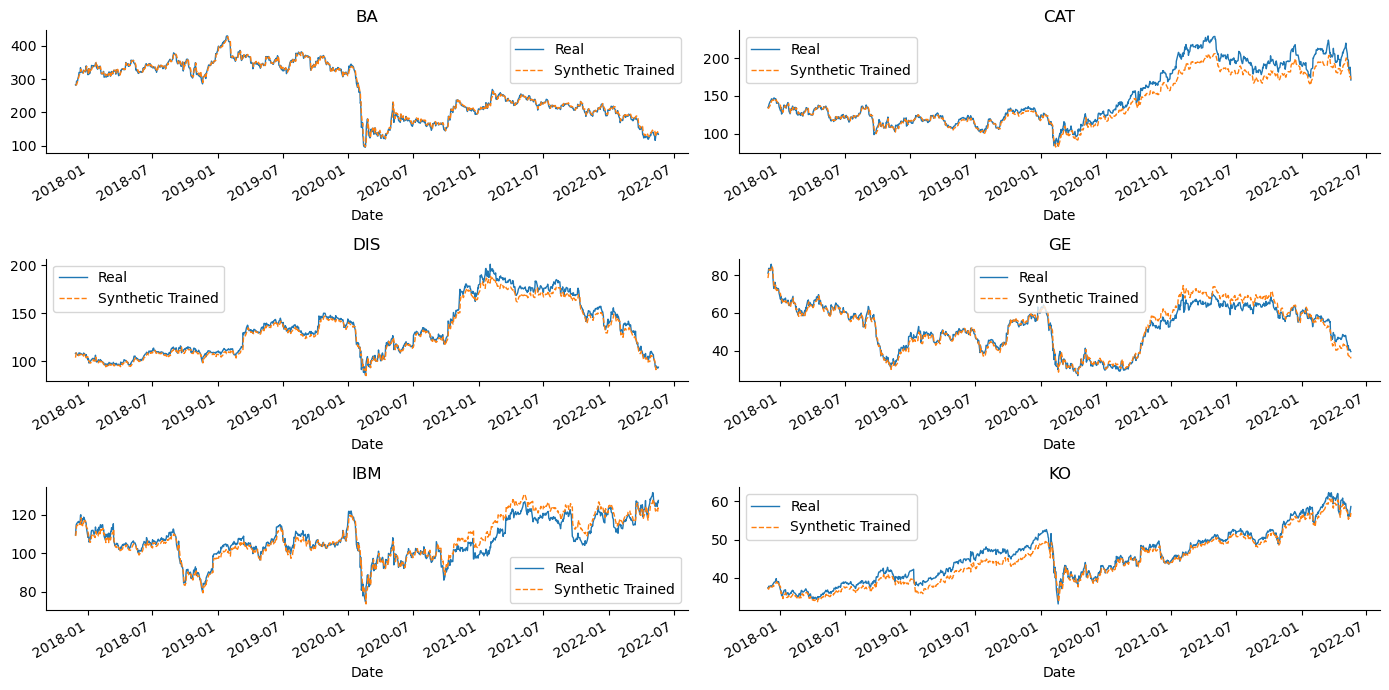

In [29]:
plot_preformance(real_unscaled, best_real_test_predict, log_dir / "real_prediction_plot")

In [30]:
stats_df = pd.concat(stats_dict, axis=1)
stats_df.to_csv(log_dir / 'real_out.csv', index=False)  

In [31]:
best_real_return_avg

157.33343645642597

In [32]:
best_real_model[2]["GE"].plot(filename=str(log_dir / "plot_ge_real.html"))

Row(id='1408', ...)

# Synthetic Looping

In [33]:
best_syn_model = None
best_syn_return_avg = 0
best_syn_test_predict = None
for k in range(iterations):
    print("Iteration: "+str(k))
    generated_data = generate_data()

    test_predict2 = model_predictions(generated_data, train_idx)
    test_predict2 = test_predict2.set_index(yf_index[test_idx])

    return_percents, stats_dict, bt_dict = backtest(test_predict2)
    return_avg = np.average(return_percents)

    if best_syn_model==None or best_syn_return_avg<return_avg:
        best_syn_model = return_percents, stats_dict, bt_dict
        best_syn_return_avg = return_avg
        best_syn_test_predict = test_predict2
        print("New Best With Returns: "+str(best_syn_model[0]))

Iteration: 0


gio: file:///home/whd20002/time_gan_research_control/experiment_00/plot_ge_real.html: Failed to find default application for content type ‘text/html’
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


New Best With Returns: [-19.80812470626828, -64.78984630599976, -39.61127513641359, 296.1817155234526, 7.304123018798818, -35.21487978141785]
Iteration: 1


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


New Best With Returns: [70.16014387573243, 65.30441549591065, 6.763027372131364, 690.694514390602, -2.8145855798339654, 12.043861070861823]
Iteration: 3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 8


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 9


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 10


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 11


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 12


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 13


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Iteration: 14


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


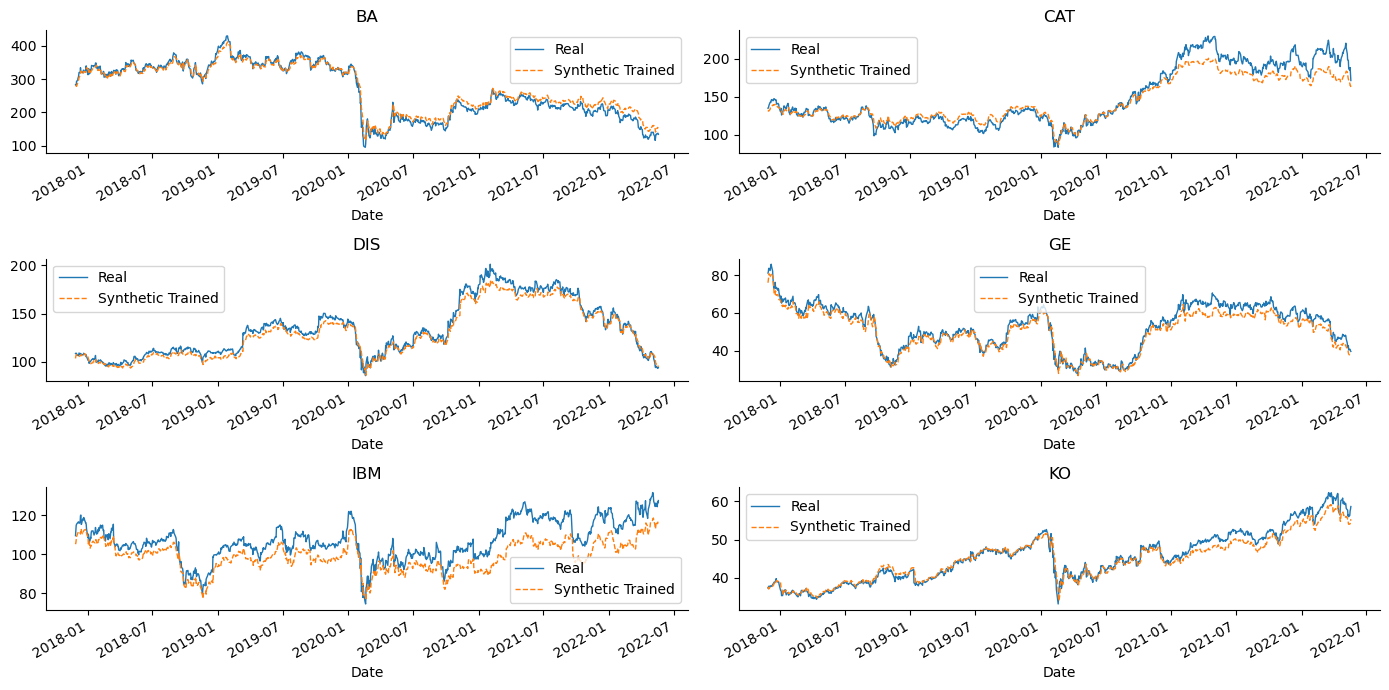

In [34]:
plot_preformance(real_unscaled, best_syn_test_predict, log_dir / "syn_prediction_plot")

In [35]:
stats_syn_df = pd.concat(best_syn_model[1], axis=1)
stats_syn_df.to_csv(log_dir / 'syn_out.csv', index=False)  

In [36]:
best_syn_model[2]["IBM"].plot(filename=str(log_dir / "plot_ge_syn.html"))

Row(id='2428', ...)

In [37]:
best_syn_return_avg

140.3585627709007

gio: file:///home/whd20002/time_gan_research_control/experiment_00/plot_ge_syn.html: Failed to find default application for content type ‘text/html’
